The notebook is based on Ksenia's ntoebook and exploring some further applications.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import defaultdict
from collections import Counter

from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

#Import Dataset

In [4]:
df = pd.read_csv(r"/content/drive/MyDrive/My_Omdena_Folder/MultiModal Lung Disease Detection/Data/padchest_pneumonia_normal_en.csv")


In [5]:
df.head()

,ImageID,StudyDate_DICOM,StudyID,PatientID,PatientBirth,PatientSex_DICOM,ViewPosition_DICOM,ReportID,Pediatric,Report,MethodLabel,Labels,Localizations,LabelsLocalizationsBySentence,PatientAge,Report_en_ChatGPT,Report_en_GoogleTr
0,20536686640136348236148679891455886468_k6ga29.png,20140915,20536686640136348236148679891455886468,839860488694292331637988235681460987,1930.0,F,POSTEROANTERIOR,4765777,NO,sin hallazg patolog edad pacient,Physician,normal,[],"[['normal'], ['normal']]",84.0,There are no pathological findings in the pati...,no finding pathology patient age
1,238285621348398466668514178112618553012_a7k6dv...,20171024,238285621348398466668514178112618553012,76478060312810134599679306720116852498,1987.0,F,POSTEROANTERIOR,5498692,NO,sin alter radiolog significacion,Physician,normal,[],"[['normal'], ['normal']]",30.0,"Translation: ""Without any other significant ra...",without alter radiolog significance
2,152191969602076825998375638267191596461_ck9qkz...,20150508,152191969602076825998375638267191596461,211676018114322936525876155155978326212,1958.0,F,POSTEROANTERIOR,4913344,NO,sin hallazg radiolog signific,Physician,normal,[],[['normal']],57.0,"Translation: ""no significant radiological find...",no significant radiological finding
3,84289138814897824414670894017743137660_xjsw7k.png,20140414,84289138814897824414670894017743137660,132905598244344199302356904572008903408,1997.0,F,POSTEROANTERIOR,4674875,PED,normal,Physician,normal,[],"[['normal'], ['normal']]",17.0,"""Normal""",normal
4,243837679625088918208093479515843617254_zotvy7...,20160210,243837679625088918208093479515843617254,122113458248232192114674752959967366181,1976.0,F,LATERAL,5084816,NO,siluet cardiomediastin dentr normal parenqu...,Physician,normal,"['loc cardiac', 'loc costophrenic angle']","[['normal'], ['normal'], ['normal', 'loc cardi...",40.0,"Text: ""Normal silhouette in cardiomediatinum a...",Siluet cardiomediastin within normal lung pare...


# Explore Dataset

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7975 entries, 0 to 7974
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ImageID                        7975 non-null   object 
 1   StudyDate_DICOM                7975 non-null   int64  
 2   StudyID                        7975 non-null   object 
 3   PatientID                      7975 non-null   object 
 4   PatientBirth                   7975 non-null   float64
 5   PatientSex_DICOM               7975 non-null   object 
 6   ViewPosition_DICOM             7975 non-null   object 
 7   ReportID                       7975 non-null   int64  
 8   Pediatric                      7975 non-null   object 
 9   Report                         7972 non-null   object 
 10  MethodLabel                    7975 non-null   object 
 11  Labels                         7975 non-null   object 
 12  Localizations                  7975 non-null   o

In [7]:
missing_values = df.isna().sum()
missing_values = missing_values[missing_values > 0]
missing_values

Report                3
Report_en_GoogleTr    3
dtype: int64

In [8]:
df = df.dropna()
df.shape

(7972, 17)

In [9]:
df[df['Labels']=='pneumonia'].shape

(523, 17)

In [10]:
df[df['Labels']=='normal'].shape

(7449, 17)

> Data is heavily unbalanced as shown.

Text(0.5, 1.0, 'Labels distribution')

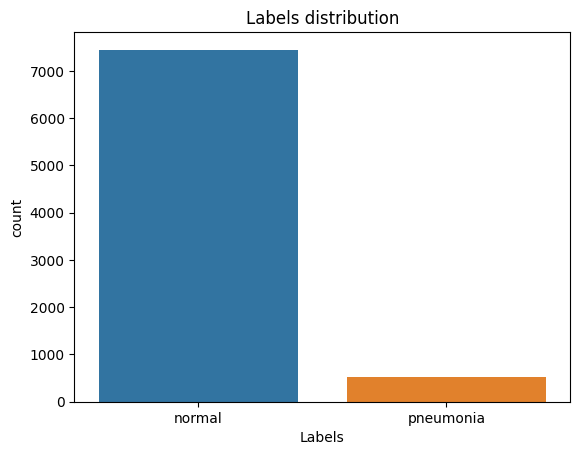

In [11]:
sns.countplot(x=df['Labels'])
plt.title('Labels distribution')

#Text Preprocessing

In [12]:
# normalize

df['Report_en_ChatGPT'] = df['Report_en_ChatGPT'].str.lower()
df.head(3)

,ImageID,StudyDate_DICOM,StudyID,PatientID,PatientBirth,PatientSex_DICOM,ViewPosition_DICOM,ReportID,Pediatric,Report,MethodLabel,Labels,Localizations,LabelsLocalizationsBySentence,PatientAge,Report_en_ChatGPT,Report_en_GoogleTr
0,20536686640136348236148679891455886468_k6ga29.png,20140915,20536686640136348236148679891455886468,839860488694292331637988235681460987,1930.0,F,POSTEROANTERIOR,4765777,NO,sin hallazg patolog edad pacient,Physician,normal,[],"[['normal'], ['normal']]",84.0,there are no pathological findings in the pati...,no finding pathology patient age
1,238285621348398466668514178112618553012_a7k6dv...,20171024,238285621348398466668514178112618553012,76478060312810134599679306720116852498,1987.0,F,POSTEROANTERIOR,5498692,NO,sin alter radiolog significacion,Physician,normal,[],"[['normal'], ['normal']]",30.0,"translation: ""without any other significant ra...",without alter radiolog significance
2,152191969602076825998375638267191596461_ck9qkz...,20150508,152191969602076825998375638267191596461,211676018114322936525876155155978326212,1958.0,F,POSTEROANTERIOR,4913344,NO,sin hallazg radiolog signific,Physician,normal,[],[['normal']],57.0,"translation: ""no significant radiological find...",no significant radiological finding


In [13]:
# this function was originally developed by Wafa

# remove extra symbols and comments from ChatGPT

def pre_process(text):
    sentences = re.findall(r'"(.*?)"', text)
    if len(sentences)==0:
        return(text)
    elif len(sentences) >= 2:
        second_sentence = sentences[1]
        return(second_sentence)
    else:
        return(sentences[0])

In [14]:
df['Report_en_ChatGPT'] = df['Report_en_ChatGPT'].apply(lambda x : pre_process(x))
df.head(3)

,ImageID,StudyDate_DICOM,StudyID,PatientID,PatientBirth,PatientSex_DICOM,ViewPosition_DICOM,ReportID,Pediatric,Report,MethodLabel,Labels,Localizations,LabelsLocalizationsBySentence,PatientAge,Report_en_ChatGPT,Report_en_GoogleTr
0,20536686640136348236148679891455886468_k6ga29.png,20140915,20536686640136348236148679891455886468,839860488694292331637988235681460987,1930.0,F,POSTEROANTERIOR,4765777,NO,sin hallazg patolog edad pacient,Physician,normal,[],"[['normal'], ['normal']]",84.0,there are no pathological findings in the pati...,no finding pathology patient age
1,238285621348398466668514178112618553012_a7k6dv...,20171024,238285621348398466668514178112618553012,76478060312810134599679306720116852498,1987.0,F,POSTEROANTERIOR,5498692,NO,sin alter radiolog significacion,Physician,normal,[],"[['normal'], ['normal']]",30.0,without any other significant radiological mea...,without alter radiolog significance
2,152191969602076825998375638267191596461_ck9qkz...,20150508,152191969602076825998375638267191596461,211676018114322936525876155155978326212,1958.0,F,POSTEROANTERIOR,4913344,NO,sin hallazg radiolog signific,Physician,normal,[],[['normal']],57.0,no significant radiological findings,no significant radiological finding


In [52]:
df.head()

,ImageID,StudyDate_DICOM,StudyID,PatientID,PatientBirth,PatientSex_DICOM,ViewPosition_DICOM,ReportID,Pediatric,Report,MethodLabel,Labels,Localizations,LabelsLocalizationsBySentence,PatientAge,Report_en_ChatGPT,Report_en_GoogleTr
0,20536686640136348236148679891455886468_k6ga29.png,20140915,20536686640136348236148679891455886468,839860488694292331637988235681460987,1930.0,F,POSTEROANTERIOR,4765777,NO,sin hallazg patolog edad pacient,Physician,normal,[],"[['normal'], ['normal']]",84.0,"[no, pathological, findings, patient, age]",no finding pathology patient age
1,238285621348398466668514178112618553012_a7k6dv...,20171024,238285621348398466668514178112618553012,76478060312810134599679306720116852498,1987.0,F,POSTEROANTERIOR,5498692,NO,sin alter radiolog significacion,Physician,normal,[],"[['normal'], ['normal']]",30.0,"[without, significant, radiological, meaning]",without alter radiolog significance
2,152191969602076825998375638267191596461_ck9qkz...,20150508,152191969602076825998375638267191596461,211676018114322936525876155155978326212,1958.0,F,POSTEROANTERIOR,4913344,NO,sin hallazg radiolog signific,Physician,normal,[],[['normal']],57.0,"[no, significant, radiological, findings]",no significant radiological finding
3,84289138814897824414670894017743137660_xjsw7k.png,20140414,84289138814897824414670894017743137660,132905598244344199302356904572008903408,1997.0,F,POSTEROANTERIOR,4674875,PED,normal,Physician,normal,[],"[['normal'], ['normal']]",17.0,[normal],normal
4,243837679625088918208093479515843617254_zotvy7...,20160210,243837679625088918208093479515843617254,122113458248232192114674752959967366181,1976.0,F,LATERAL,5084816,NO,siluet cardiomediastin dentr normal parenqu...,Physician,normal,"['loc cardiac', 'loc costophrenic angle']","[['normal'], ['normal'], ['normal', 'loc cardi...",40.0,"[normal, silhouette, cardiomediatinum, area, n...",Siluet cardiomediastin within normal lung pare...


In [53]:
df_model_samp = df.loc[:,["Report_en_ChatGPT","Labels"]].copy()

df_model_samp.head()

,Report_en_ChatGPT,Labels
0,"[no, pathological, findings, patient, age]",normal
1,"[without, significant, radiological, meaning]",normal
2,"[no, significant, radiological, findings]",normal
3,[normal],normal
4,"[normal, silhouette, cardiomediatinum, area, n...",normal


# Stemming and Lemmatizing

In [21]:

ps = PorterStemmer()
detokenizer = TreebankWordDetokenizer()

df_model_samp['Report_en_ChatGPT'] = df_model_samp['Report_en_ChatGPT'].map(lambda x: tokenizer.tokenize(str(x)))
df_model_samp['Report_en_ChatGPT'] = df_model_samp['Report_en_ChatGPT'].map(lambda x: \
                                                                          [ps.stem(word) for word in x if not word in stop])
df_model_samp['Report_en_ChatGPT'] = df_model_samp['Report_en_ChatGPT'].map(lambda x: detokenizer.detokenize(x))
df_model_samp['Report_en_ChatGPT']

5596                           no relev find
5063                           no relev find
3461               no signific radiolog find
1243                           no relev find
3892     appreci consolid without find relev
                        ...                 
7441              explor within normal limit
2049    no appreci infiltr pulmonari condens
6000                        no signific find
6603                           no relev find
5267                                 no find
Name: Report_en_ChatGPT, Length: 7000, dtype: object

In [22]:
X = df_model_samp['Report_en_ChatGPT']
y = df_model_samp['Labels']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 0)

<!-- Exploring Multi-classification Models
The classification models which we are using:

Random Forest
Linear Support Vector Machine
Multinomial Naive Bayes
Logistic Regression. -->

## Exploring Multi-classification Models
The classification models which we are using:

>Random Forest

>Linear Support Vector Machine

>Multinomial Naive Bayes

>Logistic Regression.


In [23]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    GaussianNB(),
    LogisticRegression(random_state=0),
]

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import make_scorer, f1_score



In [25]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

# We transform each report into a vector
features = tfidf.fit_transform(df_model_samp["Report_en_ChatGPT"]).toarray()
labels = df_model_samp["Labels"]

print("Each of the %d reports is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))


Each of the 7000 reports is represented by 1061 features (TF-IDF score of unigrams and bigrams)


In [26]:
labels

5596    normal
5063    normal
3461    normal
1243    normal
3892    normal
         ...  
7441    normal
2049    normal
6000    normal
6603    normal
5267    normal
Name: Labels, Length: 7000, dtype: object

In [27]:
# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  f1_scores = cross_val_score(model, features, labels, scoring=make_scorer(f1_score, average='macro'), cv=CV)


  for fold_idx, (accuracy, f1_score_val) in enumerate(zip(accuracies, f1_scores)):
        entries.append((model_name, fold_idx, accuracy, f1_score_val))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy','f1_scores'])

In [28]:
cv_df.shape

(20, 4)

>Although we are using accuracy here as a metric, this is not advisable given the imbalance of our dataset. F1 - score would be a better metric.

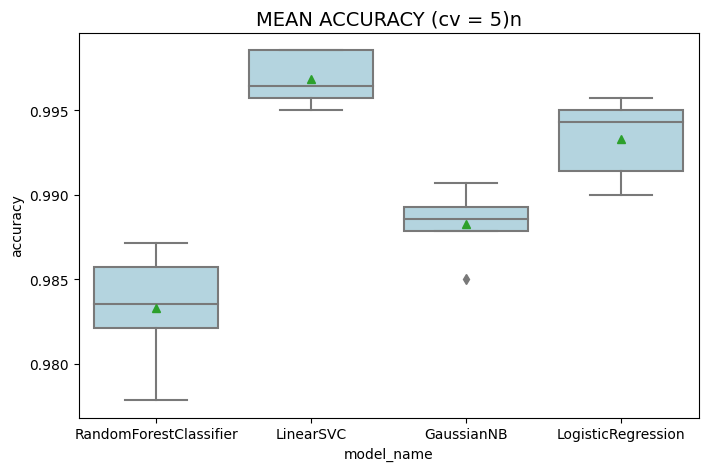

In [29]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy',
            data=cv_df,
            color='lightblue',
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)n", size=14);

In [31]:
cv_df['f1_scores_avg'] = cv_df["f1_scores"].apply(lambda x: np.mean(x))

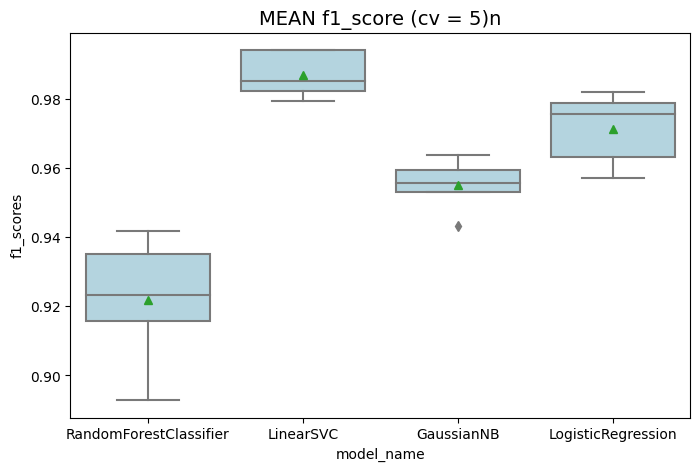

In [32]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='f1_scores',
            data=cv_df,
            color='lightblue',
            showmeans=True)
plt.title("MEAN f1_score (cv = 5)n", size=14);

#SVC

In [34]:
df_model.shape

(7972, 2)

In [35]:
df_model.head()

,Report_en_ChatGPT,Labels
0,there are no pathological findings in the pati...,normal
1,without any other significant radiological mea...,normal
2,no significant radiological findings,normal
3,normal,normal
4,"normal silhouette in cardiomediatinum area, no...",normal


In [41]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

# We transform each report into a vector
features_2 = tfidf.fit_transform(df_model["Report_en_ChatGPT"]).toarray()
labels_2 = df_model["Labels"]

print("Each of the %d reports is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features_2.shape))


Each of the 7972 reports is represented by 1305 features (TF-IDF score of unigrams and bigrams)


In [43]:
features_2.shape

(7972, 1305)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(features_2,
                                                               labels_2,
                                                               test_size=0.25,
                                                               random_state=1)

model_svc = LinearSVC()
model_svc.fit(X_train, y_train)
y_pred = model_svc.predict(X_test)

In [46]:
print(metrics.classification_report(y_test,y_pred, target_names = df_model["Labels"].unique()))

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00      1856
   pneumonia       1.00      0.99      0.99       137

    accuracy                           1.00      1993
   macro avg       1.00      0.99      1.00      1993
weighted avg       1.00      1.00      1.00      1993



Text(0.5, 25.722222222222214, 'Predicted')

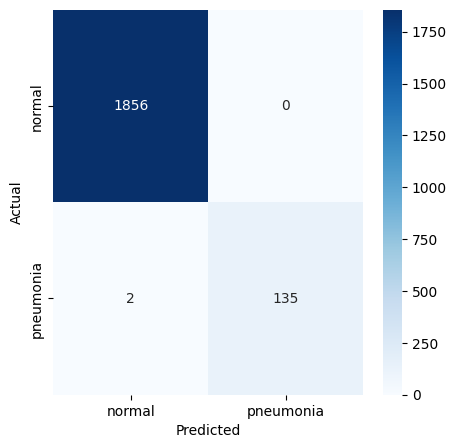

In [51]:
conf_mat =  confusion_matrix(y_test,y_pred)

fig, ax =  plt.subplots(figsize = (5,5))

sns.heatmap(conf_mat, annot =True, cmap = "Blues", fmt = 'd',
            xticklabels = df_model["Labels"].unique(),
            yticklabels = df_model["Labels"].unique())

plt.ylabel('Actual')
plt.xlabel('Predicted')